In [24]:
import pylidc

import pydicom
import os
import numpy as np

In [ ]:
path_LIDC_dataset = f"/media/joaob/Data-LINUX/LIDC-IDRI/"
files = sorted(os.listdir(path_LIDC_dataset))
files

In [ ]:
for dirpath, dirnames, filenames in os.walk(path_LIDC_dataset):
    print(f'Current Directory: {dirpath}')
    
    # Iterate through subdirectories
    for dirname in dirnames:
        print(f'\tSubdirectory: {dirname}')
    
    break
    


In [27]:
def load_dicom_slices(folder_path):
    # List to hold the slices
    slices = []
    
    # Loop through all files in the directory
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.dcm'):
            # Load the DICOM file
            dicom_file_path = os.path.join(folder_path, filename)
            dicom_data = pydicom.dcmread(dicom_file_path)
            
            # Extract pixel array (assuming it's 512x512)
            slices.append(dicom_data.pixel_array)
    
    # Stack the slices into a 3D NumPy array (slices, 512, 512)
    dicom_stack = np.stack(slices, axis=0)
    
    return dicom_stack

# Usage
folder_path = f'/media/joaob/Data-LINUX/LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192'  # Replace with the actual folder path
dicom_array = load_dicom_slices(folder_path)

print(dicom_array.shape)  # Output should be (number_of_slices, 512, 512)


(133, 512, 512)


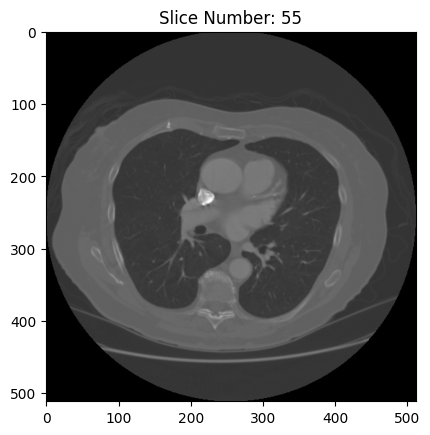

In [29]:
import matplotlib.pyplot as plt
i=55 #slice number <i>

image = dicom_array[i]
# Display the image
plt.imshow(image, cmap='gray')
plt.title(f"Slice Number: {i}")
plt.show()

In [47]:
#store in disk the aggregation of dicom images
#os.mkdir('./LIDC-DATASET/')
#os.mkdir('./LIDC-DATASET/LIDC-IDRI-0001/')
#np.save("./LIDC-DATASET/LIDC-IDRI-0001/scan.npy" , dicom_array)

#load
#np.load("./LIDC-DATASET/LIDC-IDRI-0001/scan.npy")